In [22]:
import scanpy as sc
import anndata as ad
import scanpy.external as sce
import pandas as pd
import matplotlib.pyplot as plt
import scvi
import torch
import scipy.sparse as sp

from rich import print
import warnings
warnings.filterwarnings("ignore")
import os

outdir = "/Users/jessica/Documents/GitHub/Jessica_notebooks/write/02_batch_annotation/PICA0001-PICA0007"
os.makedirs(outdir, exist_ok=True)
sc.settings.figdir = "/Users/jessica/Documents/GitHub/Jessica_notebooks/figures/PICA0001-PICA0007/02_annotation"



In [6]:
# Load preprocessed adata
adata = sc.read_h5ad("/Users/jessica/Documents/GitHub/Jessica_notebooks/write/02_batch_annotation/PICA0001-PICA0007/PICA0001-PICA0007_preprocessed.h5ad")
adata.var_names_make_unique()
print(adata)

AnnData object with n_obs × n_vars = 10059 × 38606
    obs: 'status', 'assignment', 'pica_id', 'pool_id', 'sequencing_batch', 'n_genes_by_counts', 
'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 
'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 
'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 
'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'status_manual', 'cell_type', 
'status_manual_01_b_subset', 'broad_cell_type', 'cell_type_01_b_cell', 'cell_type_01_b_cell_corrected', 
'cell_type_02_t_cell_broad', 'cell_type_03_t_cell_subtype', 'cell_type_04_myeloid_subset', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts-0', 'mean_counts-0', 
'log1p_mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'log1p_total_counts-0', 'n_cells_by_counts-1', 
'mean_counts-1', 'log1p_mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'log1p_total_counts-1', 
'n_cells_by_counts-2', 'mean_counts-2', 'log1p_mean_counts-2', 'pct_dropout_by_counts-2', 'total_counts-2', 
'log1p_total_counts-2', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 
'highly_variable_intersection'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'pica_id_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

#### 1. Batch integration with scVI

In [7]:
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="pica_id")

In [8]:
model = scvi.model.SCVI(adata, n_layers=2, n_latent=30, gene_likelihood="nb")

In [9]:
model.train()

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 400/400: 100%|██████████| 400/400 [3:22:10<00:00, 39.08s/it, v_num=1, train_loss_step=7.44e+3, train_loss_epoch=7.82e+3]  

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [3:22:10<00:00, 30.33s/it, v_num=1, train_loss_step=7.44e+3, train_loss_epoch=7.82e+3]


Epoch 4/400:   1%|          | 3/400 [3:26:24<455:14:25, 4128.13s/it, v_num=1, train_loss_step=8.44e+3, train_loss_epoch=8.56e+3]


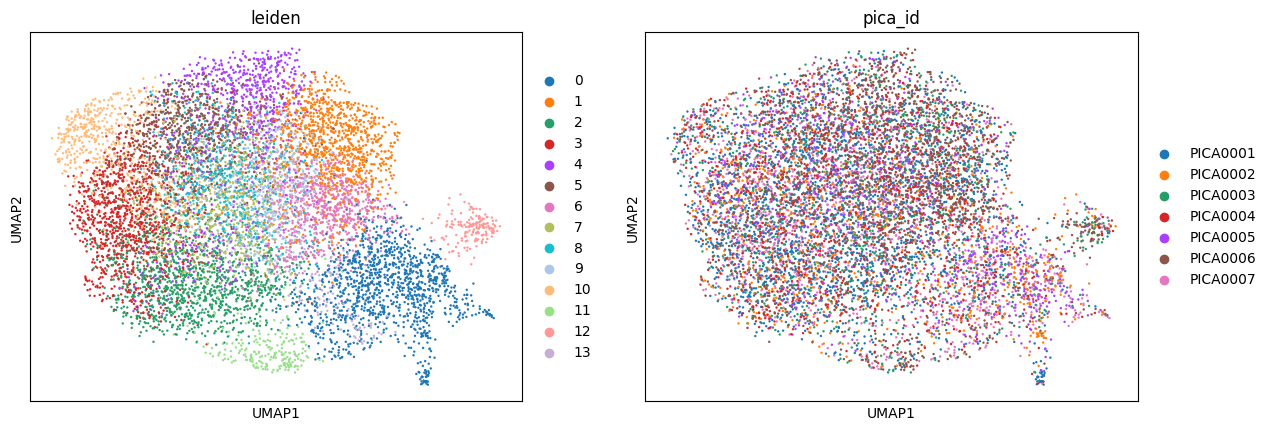

In [10]:
adata.obsm["X_scVI"] = model.get_latent_representation()

#  latent representation 
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata)
sc.tl.leiden(adata)


sc.pl.umap(adata, color=["leiden", "pica_id"], save="scvi_integrated_umap.png")

In [11]:
# Save the scVI integrated batch adata
adata.write_h5ad("/Users/jessica/Documents/GitHub/Jessica_notebooks/write/02_batch_annotation//PICA0001-PICA0007/PICA0001-PICA0007_scVI.h5ad", compression='gzip')

### Introduce metadata eg. age?

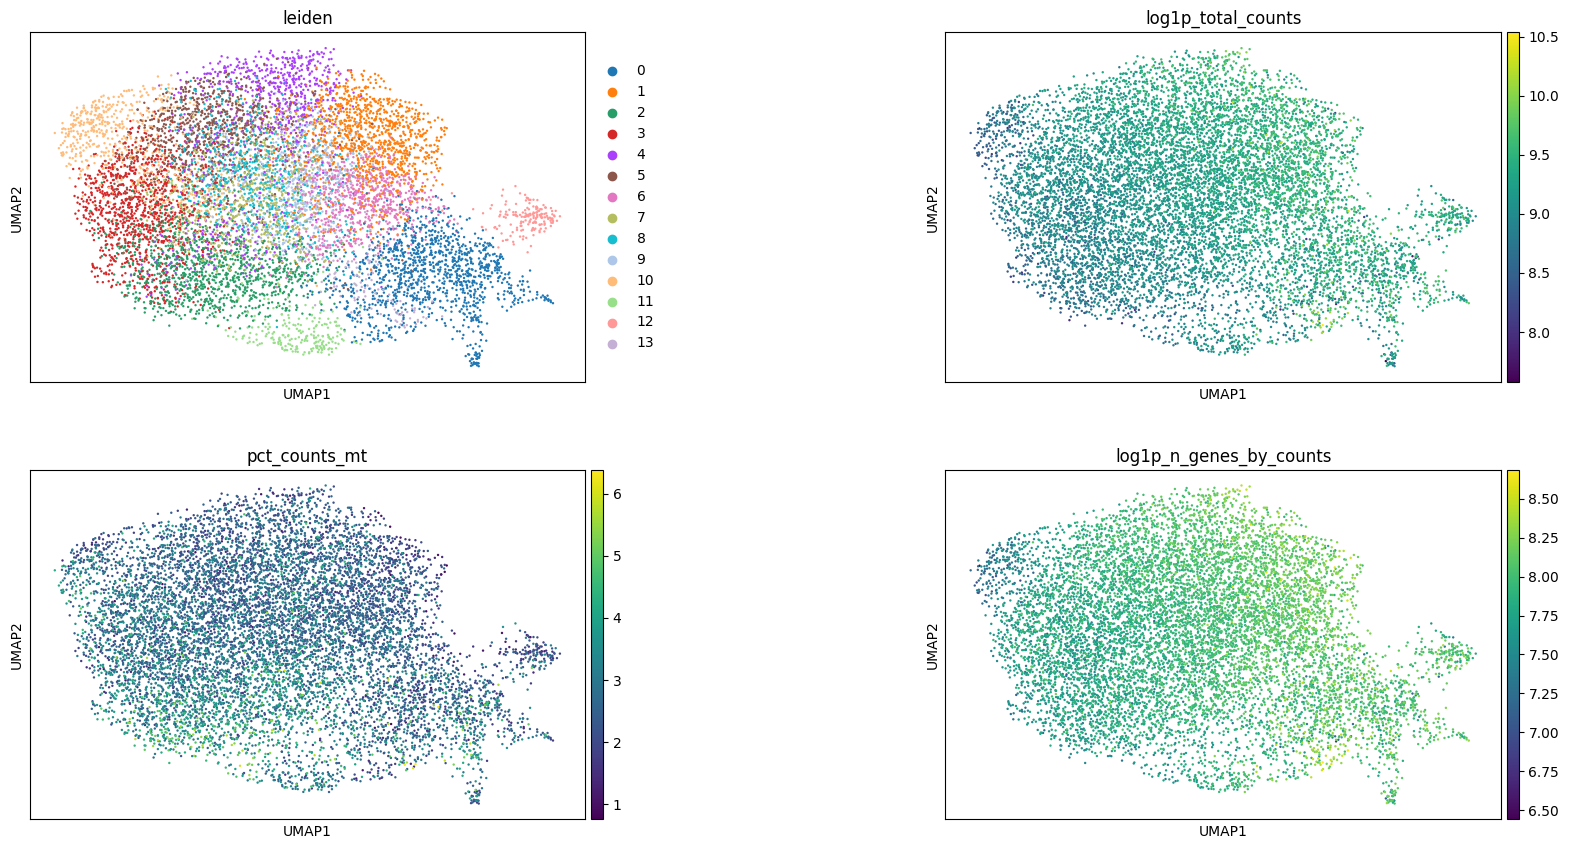

In [12]:
sc.pl.umap(
    adata,
    color=["leiden", "log1p_total_counts", "pct_counts_mt", "log1p_n_genes_by_counts"],
    wspace=0.5,
    ncols=2,
)

#### 2. Clustering
- resolutions
- known marker genes to see if they align with cluster size

In [13]:
# Test different resolutions for Leiden clustering
# Higher resolution will result in more clusters, lower resolution will result in fewer clusters
for res in [0.02, 0.5, 1.0, 2.0]:
    sc.tl.leiden(
        adata, key_added=f"leiden_res_{res:4.2f}", resolution=res, flavor="igraph"
    )

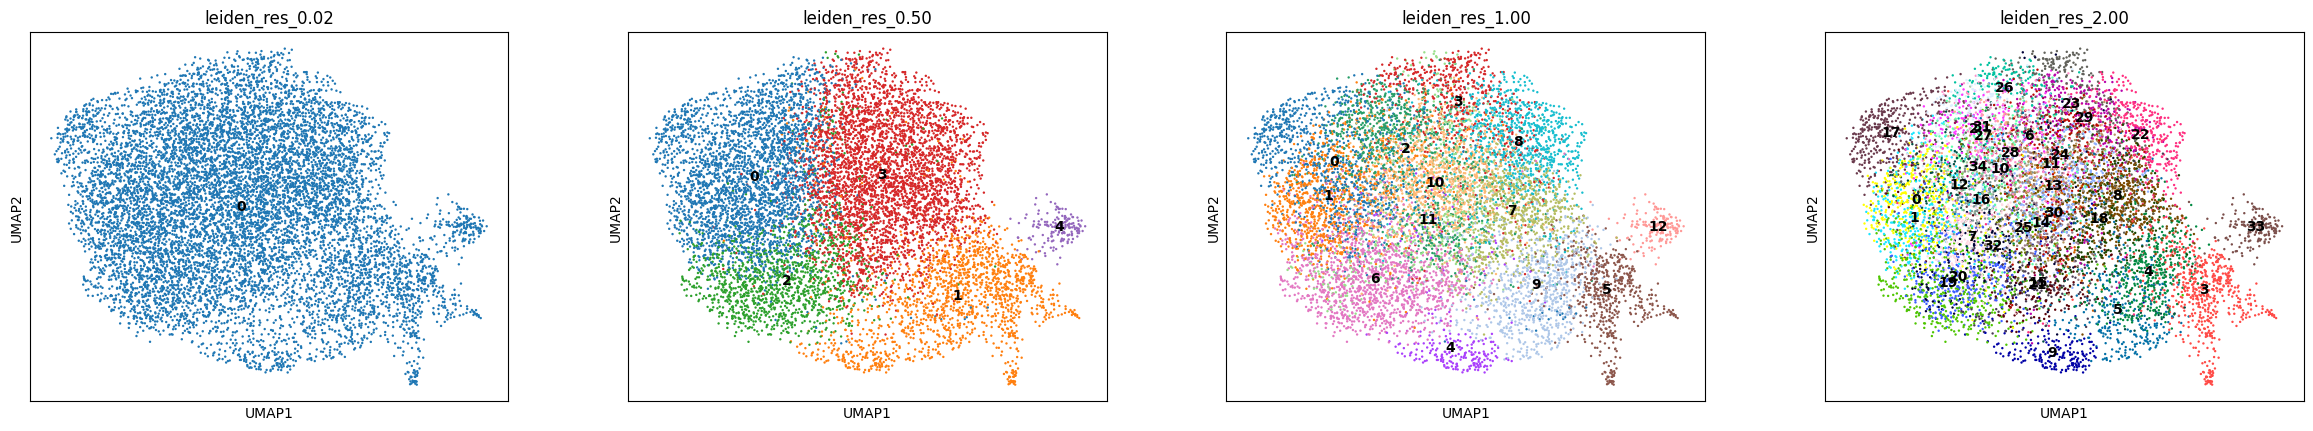

In [14]:
sc.pl.umap(
    adata,
    color=["leiden_res_0.02", "leiden_res_0.50", "leiden_res_1.00", "leiden_res_2.00"],
    legend_loc="on data",
)

In [17]:
adata.obs["leiden"].value_counts()      # Check cluster sizes

leiden
0     1235
1     1107
2     1103
3     1061
4      861
5      821
6      726
7      699
8      657
9      631
10     610
11     243
12     171
13     134
Name: count, dtype: int64

In [18]:
# check proportion of pica_id in each clusters
sc.tl.paga(adata, groups='leiden')
pd.crosstab(adata.obs['pica_id'], adata.obs['leiden'], normalize= 'index')

leiden           0         1         2         3         4         5  \
pica_id                                                                
PICA0001  0.078936  0.103033  0.159535  0.121728  0.068135  0.113835   
PICA0002  0.242661  0.052838  0.159491  0.112524  0.037182  0.082192   
PICA0003  0.056743  0.171053  0.111842  0.082237  0.112664  0.069901   
PICA0004  0.081549  0.121911  0.133443  0.103789  0.084020  0.098847   
PICA0005  0.290698  0.093023  0.049419  0.072674  0.059593  0.114826   
PICA0006  0.055726  0.167789  0.042866  0.075934  0.151868  0.049602   
PICA0007  0.179883  0.059074  0.081958  0.134646  0.069718  0.052155   

leiden           6         7         8         9        10        11  \
pica_id                                                                
PICA0001  0.072289  0.068550  0.055671  0.058164  0.062734  0.023681   
PICA0002  0.044031  0.077299  0.046967  0.034247  0.066536  0.018591   
PICA0003  0.060855  0.064145  0.058388  0.080592  0.055099  0.027961   
PICA0004  0.085667  0.066722  0.075783  0.046952  0.051071  0.021417   
PICA0005  0.042151  0.079942  0.063953  0.061047  0.037791  0.004360   
PICA0006  0.126761  0.044703  0.067973  0.084507  0.045315  0.033068   
PICA0007  0.049494  0.089409  0.083555  0.064396  0.086216  0.026610   

leiden          12        13  
pica_id                       
PICA0001  0.004155  0.009555  
PICA0002  0.015656  0.009785  
PICA0003  0.039474  0.009046  
PICA0004  0.009061  0.019769  
PICA0005  0.013081  0.017442  
PICA0006  0.039192  0.014697  
PICA0007  0.006919  0.015966

#### checking small clusters for biological significance

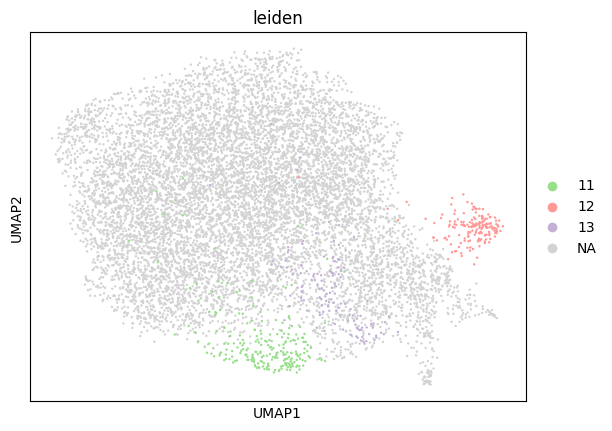

In [19]:
sc.pl.umap(adata, color='leiden', groups=['11', '12', '13'])


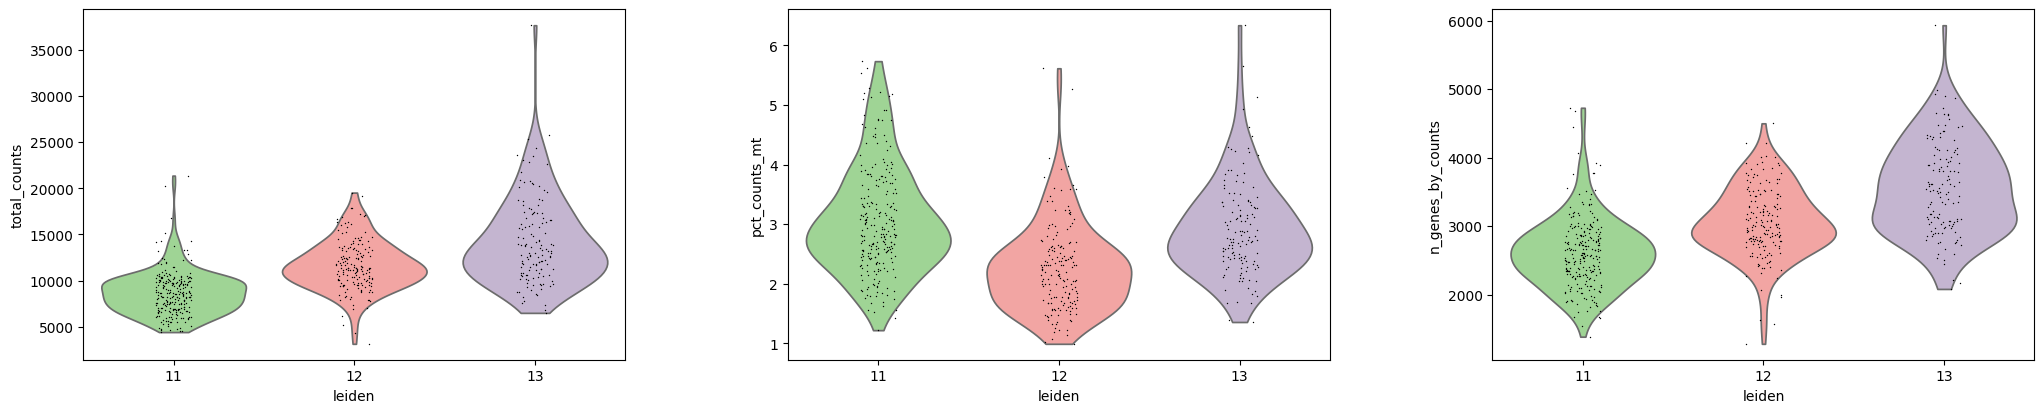

In [37]:
import seaborn as sns

adata1_sub = adata[adata.obs['leiden'].isin(['11', '12', '13'])].copy()

# Violin plots for total counts, mito%, n_genes for clusters 13, 14 and 15
sc.pl.violin(adata1_sub, ['total_counts', 'pct_counts_mt', 'n_genes_by_counts'],
             groupby='leiden', multi_panel=True, save="_small_cluster.png")

- n_genes_by_counts: \
Same ordering (11 lowest, 13 highest). This is typical of naïve → memory/activated progression; higher activation/state complexity = more genes/UMIs.
- Differences look biological, not technical: \
11 is likely naïve-like, 12 memory/activated, 13 more activated/cytotoxic or cycling.

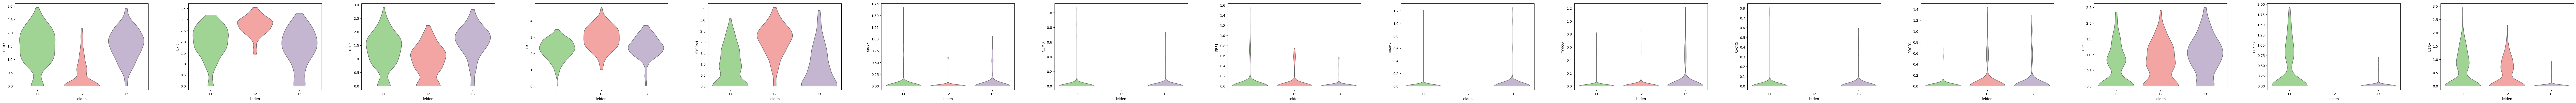

In [38]:
small_markers = [
    "CCR7","IL7R","TCF7","LTB",            # Naïve/CD4 axis
    "S100A4",                              # Memory/activation
    "NKG7","GZMB","PRF1",                  # Cytotoxic
    "MKI67","TOP2A",                       # Cycling
    "CXCR5","PDCD1","ICOS",                # cTfh
    "FOXP3","IL2RA"                        # Treg/Tfr
]

sc.pl.violin(adata1_sub, small_markers,
             groupby="leiden" , multi_panel=False, stripplot=False, 
             save="_markers_cluster.png")



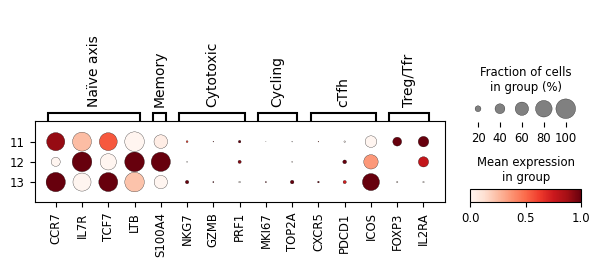

In [35]:
small_markers_labels = {
    "Naïve axis": ["CCR7","IL7R","TCF7","LTB"],
    "Memory":     ["S100A4"],
    "Cytotoxic":  ["NKG7","GZMB","PRF1"],
    "Cycling":    ["MKI67","TOP2A"],
    "cTfh":       ["CXCR5","PDCD1","ICOS"],
    "Treg/Tfr":   ["FOXP3","IL2RA"],
}
sc.pl.dotplot(adata1_sub, small_markers_labels, groupby="leiden", standard_scale="var", save="_markers_grouped_dotplot.png")

####
Treg/Tfr \
11 - strong expression of CD3E --> T cell identity ( T helper) \

memory/ effector CD4 \
12 - strong expression in S100A4 + low in cTfh and Treg markers \

cTfH \
13 - strong expression of CXCR5 / PDCD1 / ICOS

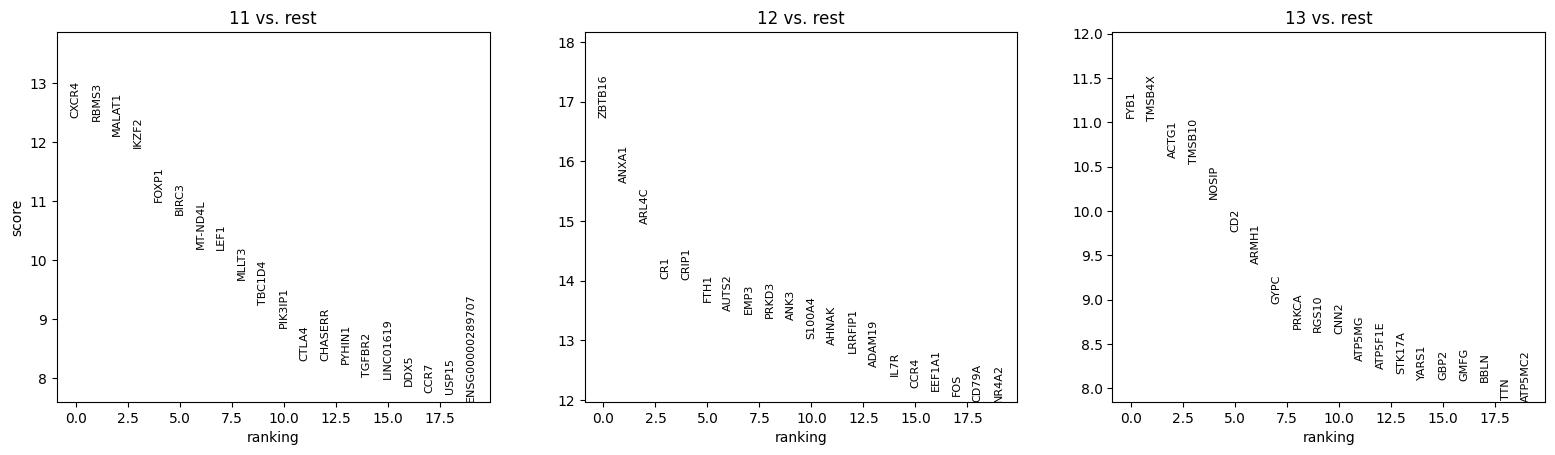

In [39]:
sc.tl.rank_genes_groups(adata1_sub, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata1_sub, n_genes=20, sharey=False)

In [ ]:
# Save the clustered adata
adata.write_h5ad("/Users/jessica/Documents/GitHub/Jessica_notebooks/write/02_batch_annotation/PICA0001-PICA0007/PICA0001-PICA0007_scVI_cluster.h5ad", compression='gzip')

##### 3. Annotation

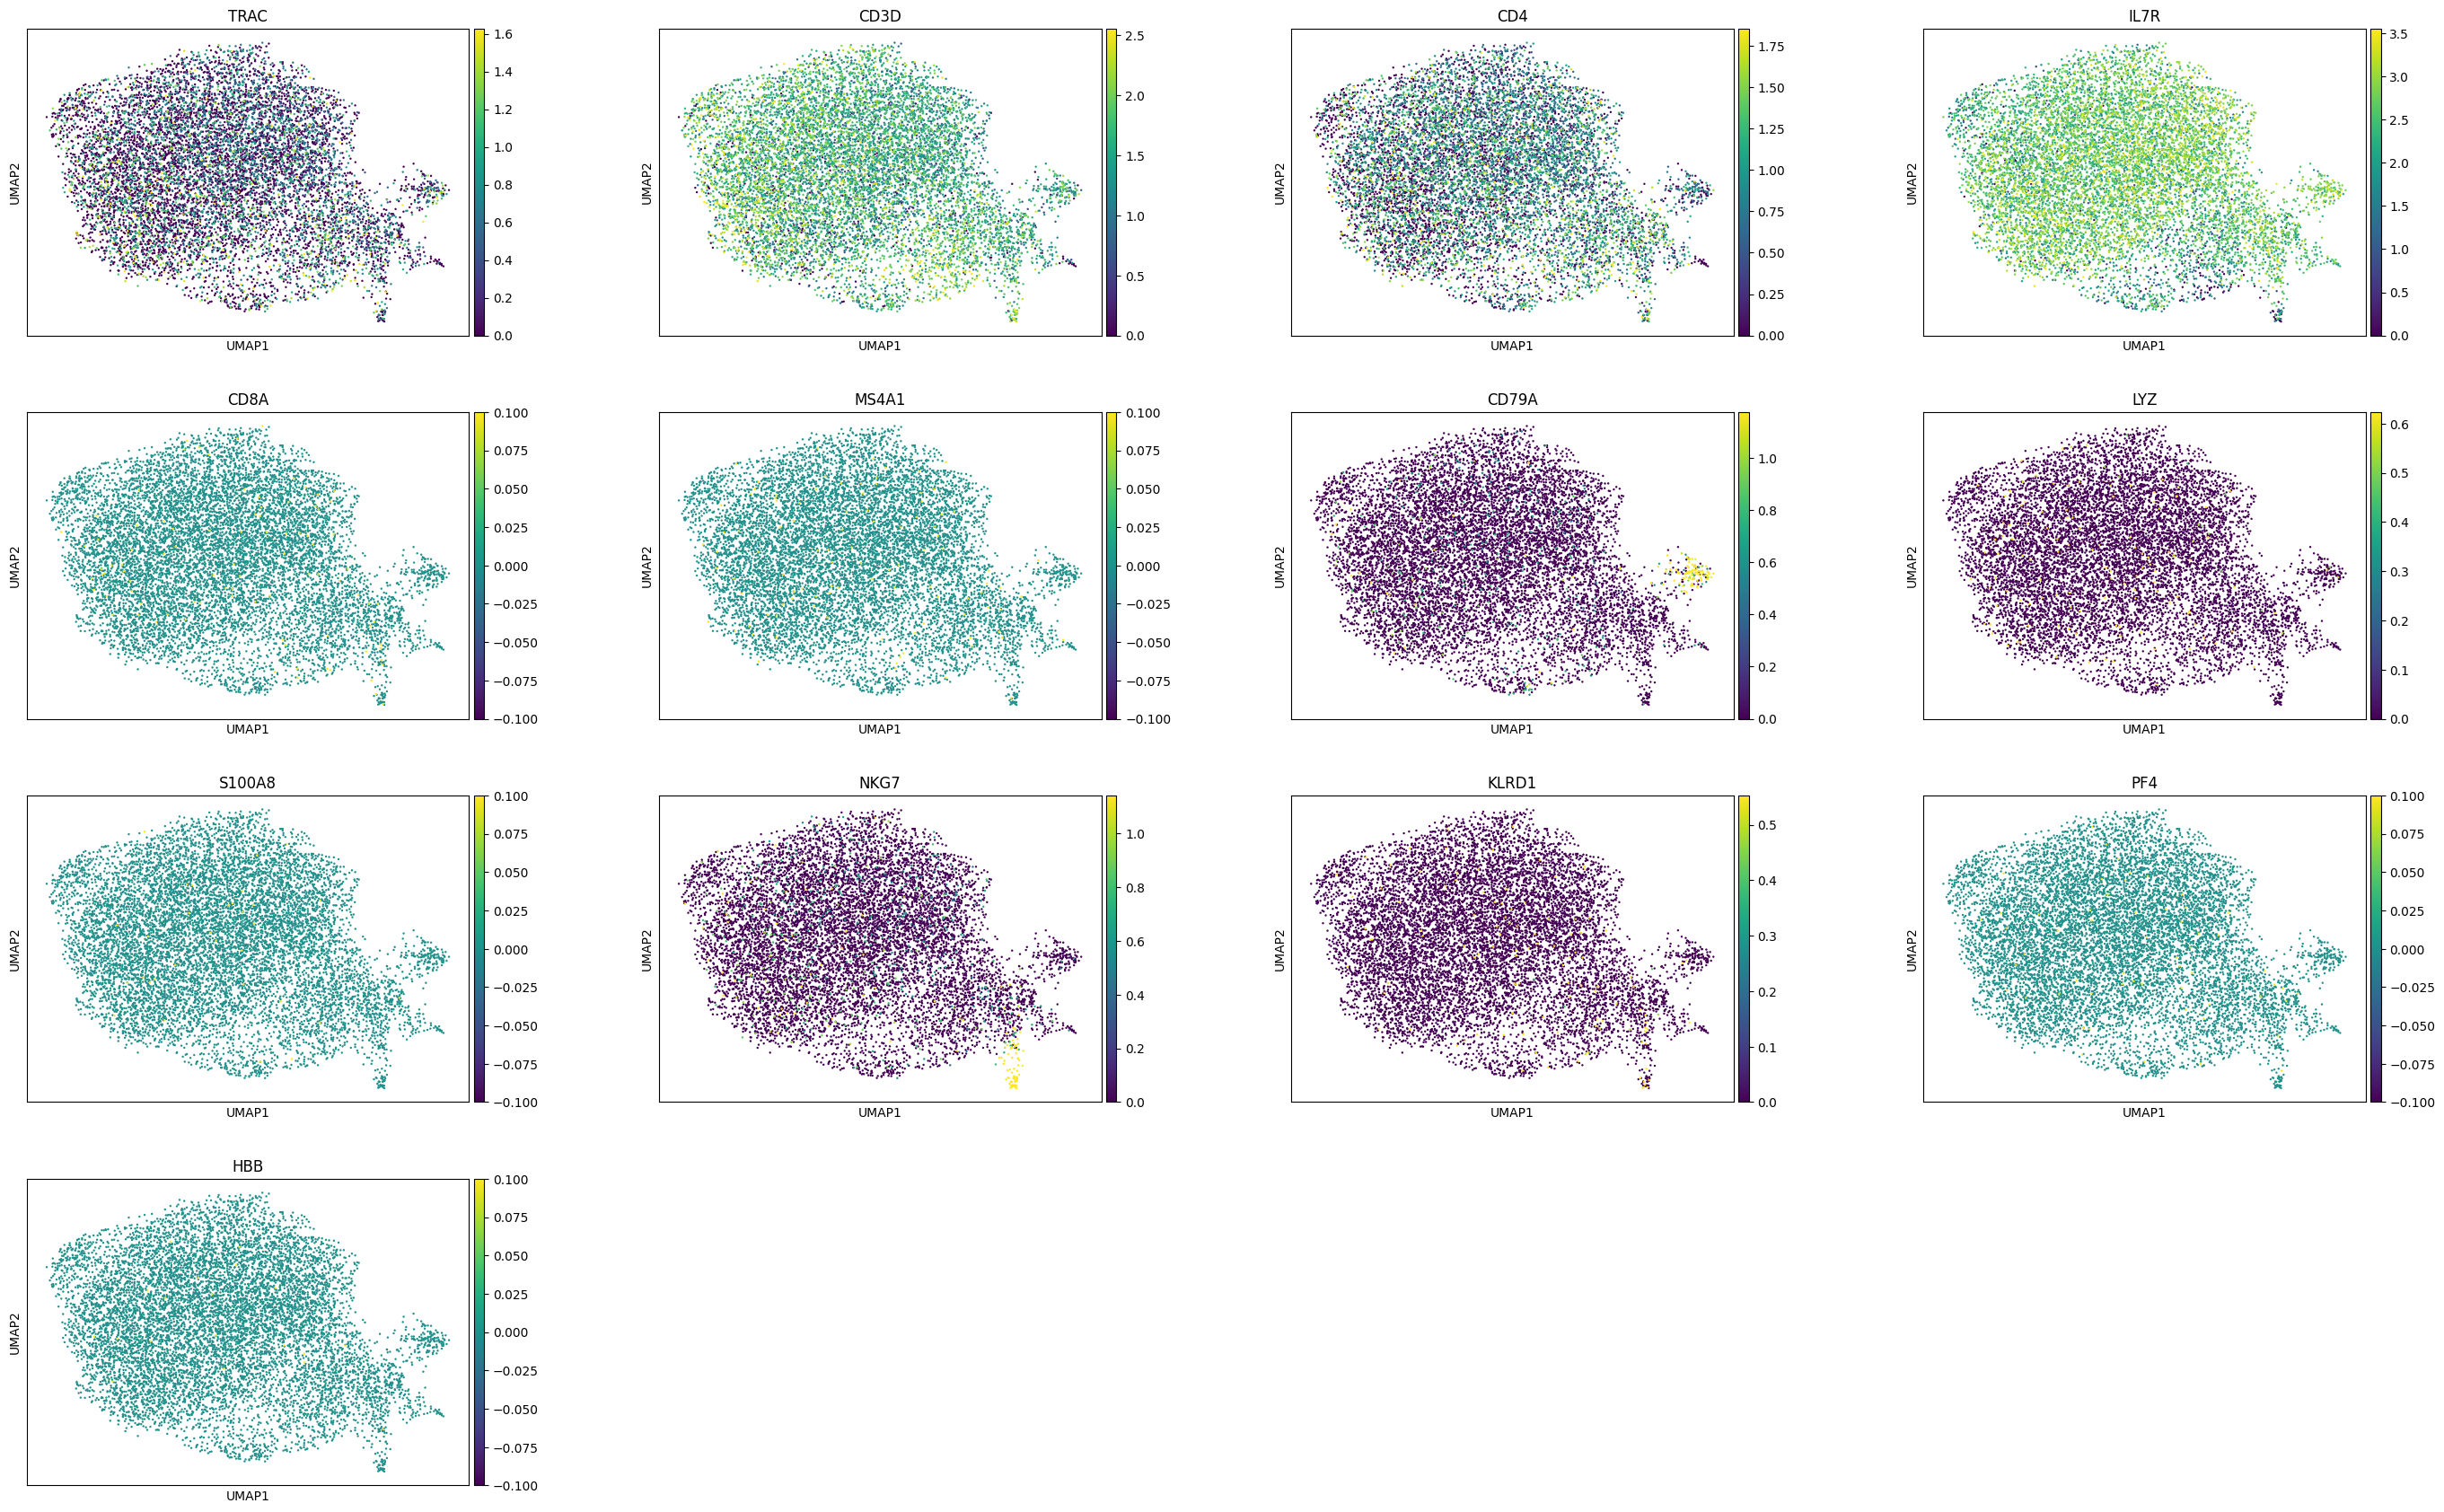

In [15]:
# Validate CD4 subset
sc.pl.umap(
    adata, 
    color=["TRAC","CD3D","CD4","IL7R",
           "CD8A","MS4A1","CD79A","LYZ",
           "S100A8","NKG7","KLRD1","PF4","HBB"],
    vmin=0, vmax="p99", wspace=0.3
)  # example for T-cells, B-cells, monocytes, platelets

T lineage: RAC and CD3D high across 
CD4: CD4 and IL7R widespread signal

CD8a exclusion
MS4A1 (B cell), LYZ (myeloid), PF4 (platelet), HBB (RBC) flat
Cytotoxic pocket: a small island with NKG7 positivity; KLRD1 looks low there, so that’s consistent with CD4 cytotoxic T cells (keep), not NK

Double-confirm that NKG7+ island is T (should be TRAC+, KLRD1 low).
Move to cTfh/Tfr localization:
Overlay CXCR5, PDCD1, ICOS and FOXP3, IL2RA.
You want a CXCR5/PD1/ICOS island separate from FOXP3/IL2RA (Tfr).

** minimal non-T cell contamination

In [ ]:
marker_genes = {
    "B cell": ["BLNK", "CD19", "CD79A", "CD79B", "MS4A1", "CD37", "CD79A"],
    "Plasmablast": ["CD19", "CD24", "CD38"], # experiment
    "Dendritic cell": ["CLEC4C", "IL3RA", "NRP1", "CD1C", "CST3", "FCER1A", "CD123", "GZMB"],
    "Endothelial cell": ["CDH5", "SELE", "VWF"],
    "Fibroblast": ["COL1A1", "COL3A1", "FAP", "THY1"],
    'Neutrophils': ['S100A8', 'S100A9', 'CEACAM8', 'ELANE', 'CSF3R', 'MPO'],  # CEACAM8 is highly specific neutrophil marker
    'Eosinophils': ['IL5RA', 'CCR3', 'EPX', 'PRG2', 'GATA1', 'CLC'],  
    'Basophils': ['FCER1A', 'KIT', 'CPA3', 'HPGDS', 'ENPP3'],  
    "Classical monocyte": ["CD14", "FCGR3A", "LYZ", "FCGR1A", 'CCR2', 'S100A8', 'S100A9'], # CD14⁺ CD16/FCGR3A⁻
    "Intermediate monocyte": ["CD14", "FCGR3A", "HLA-DRA", "CCL2", 'ITGAX'], # CD14⁺ CD16⁺
    "Non-classical monocyte": ["CD14", "FCGR3A", "TREML4", "NR4A1", 'CX3CR1', 'HLA-DPB1'], # CD14⁻CD16⁺
    "Natural killer cell": ["CCL3", 'CD160', 'CD247', 'GNLY', 'GZMB', 'NKG7', 'FCGR3A', 'FCGR3B', 'KLRB1', 'KLRC1', 'KLRD1', 'KLRF1', 'KLRK1', 'NCAM1'],
    "Platelet": ["CD41", "ITGA2B", "CD34", "CD61", "PF4", 'PLA2G12A', 'PPBP'], # No megakaryocyte in blood
    'HSPC': ['CD34', 'CD38', 'THY1', 'KIT', 'PROM1', 'SLAMF1', 'ITGA6'],
    "T cell": ['CD3D', 'CD3E', 'CD3G', 'TRAC', 'TRBC1', 'TRDC'],
    "CD4+ memory T cell": ['CCR7', 'CD27', 'IL7R'],
    "CD4+ T cell": ['CD4', 'CTLA4', 'FOXP3', 'IL2RA'],
    "CD8+ T cell": ['CD4', 'CD8A', 'CD8B', 'GZMK'],
    "Naive T cell": ['CCR7', 'CD27', 'CD8A', 'CD8B'],
    "Natural killer T (NKT) cell": ['CD8A', 'CD8B', 'ZNF683'],
}